In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5

IMG_CHANNELS = 3


In [3]:
IMG_PATH = r'C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\train\images'
LABELS_PATH = r'C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\train\labels'
IMG_PATH_TEST = r'C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\test\images'
LABELS_PATH_TEST = r'C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\test\labels'

In [4]:
print("Image Path:", IMG_PATH)
print("Labels Path:", LABELS_PATH)
print("Test Image Path:", IMG_PATH_TEST)
print("Test Labels Path:", LABELS_PATH_TEST)


Image Path: C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\train\images
Labels Path: C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\train\labels
Test Image Path: C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\test\images
Test Labels Path: C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\oil-spill\test\labels


In [5]:
import os

try:
    IMG_IDS = sorted(os.listdir(IMG_PATH))
    LABELS_IDS = sorted(os.listdir(LABELS_PATH))
    IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
    LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check that the directory exists.")


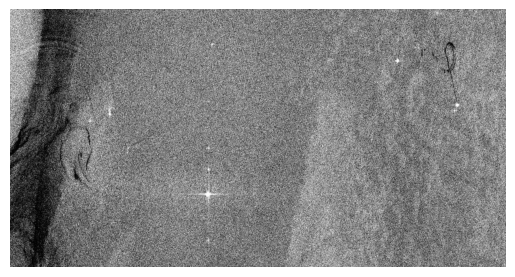

Randomly selected image: img_0006.jpg


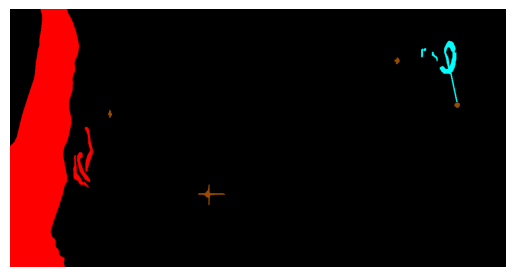

Randomly selected mask: img_0006.png


In [6]:
# Choose a random image and mask filename from the list
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [7]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [8]:
train_images = []
train_masks = []

test_images = []
test_masks = []

In [9]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)


100%|██████████| 1002/1002 [00:23<00:00, 43.42it/s]


In [10]:
train_masks.shape

(1002, 256, 256, 1)

In [11]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


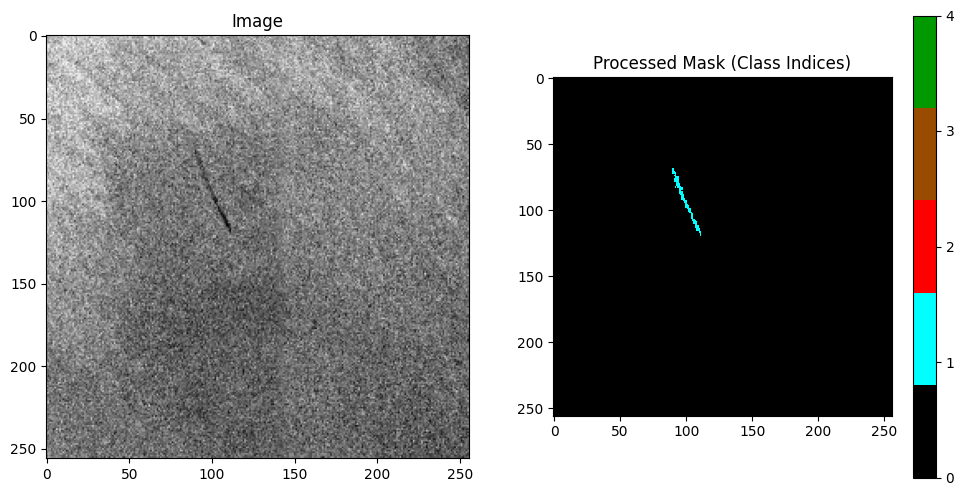

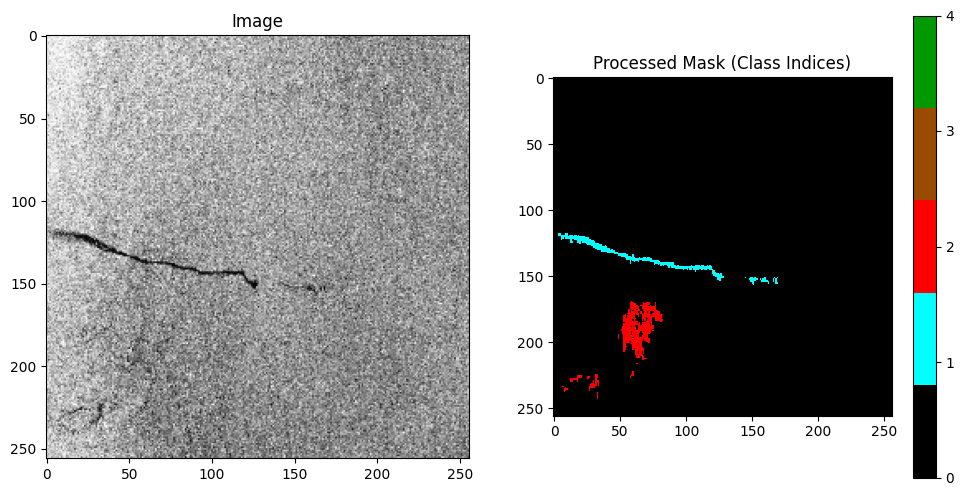

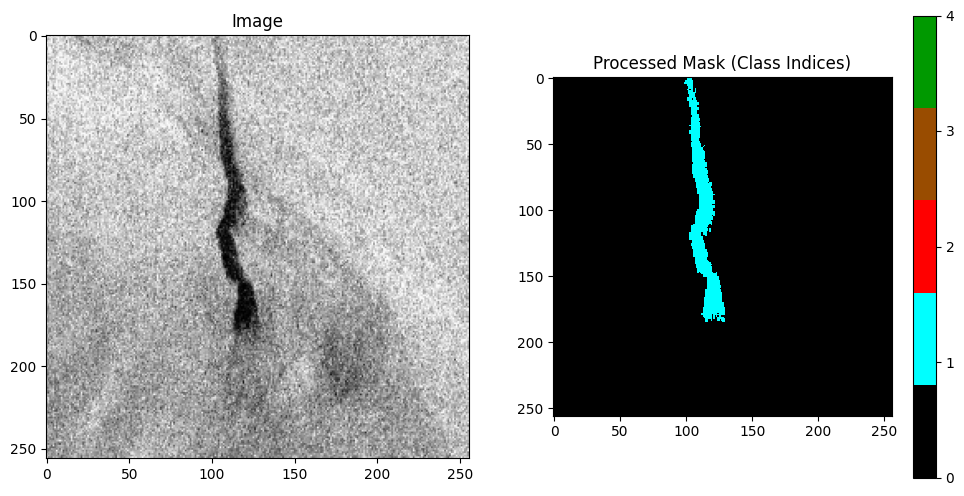

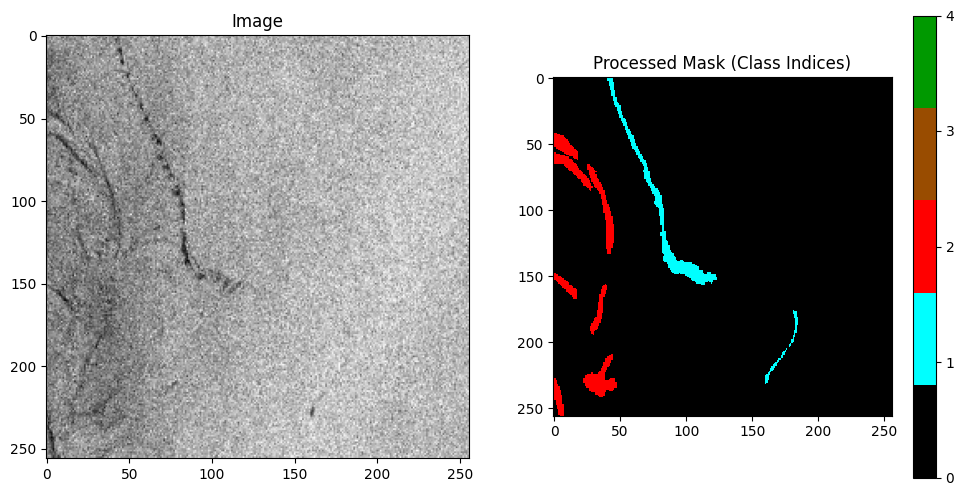

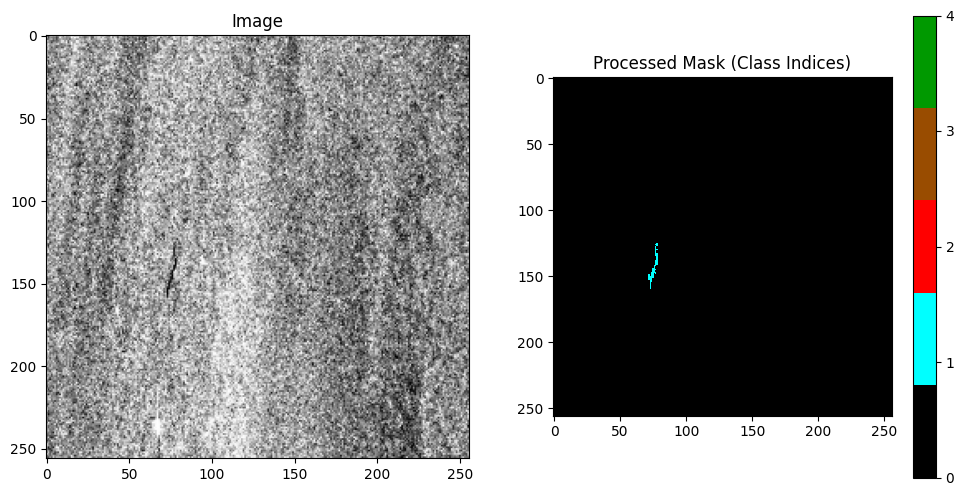

In [12]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [13]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)


100%|██████████| 110/110 [00:02<00:00, 38.13it/s]


In [14]:
test_masks.shape

(110, 256, 256, 1)

In [15]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


In [16]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)


In [17]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [18]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [19]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


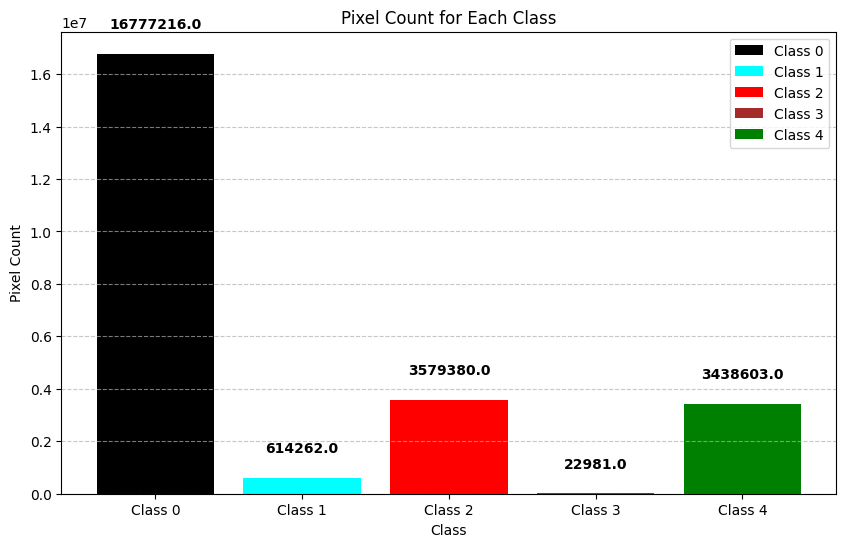

In [20]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()


In [21]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [22]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization, Activation, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Atrous Spatial Pyramid Pooling
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y


In [23]:
# Hybrid Model combining UNet and DeepLabV3+
def HybridModel(input_shape, IMG_CLASSES):
    # Encoder: ResNet50
    inputs = Input(input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Pre-trained ResNet50 Layers
    low_level_features = base_model.get_layer('conv2_block2_out').output
    encoder_output = base_model.get_layer('conv4_block6_out').output

    # ASPP at the bottleneck
    bottleneck = ASPP(encoder_output)

    # Decoder: UNet-style
    up1 = UpSampling2D((4, 4), interpolation='bilinear')(bottleneck)
    low_features = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(low_level_features)
    low_features = BatchNormalization()(low_features)
    low_features = Activation('relu')(low_features)
    concat1 = concatenate([up1, low_features])

    conv1 = Conv2D(256, (3, 3), padding='same', use_bias=False)(concat1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    up2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer="he_normal", padding="same")(up2)
    conv2 = Dropout(0.2)(conv2)

    up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv2)
    conv3 = Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(up3)
    conv3 = Dropout(0.2)(conv3)

    outputs = Conv2D(IMG_CLASSES, (1, 1), activation="softmax")(conv3)

    model = Model(inputs, outputs)
    return model

# Instantiate and compile the model
hybrid_model = HybridModel(input_shape, IMG_CLASSES)
hybrid_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Summary of the model
hybrid_model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [24]:
# Train the Hybrid Model
hybrid_history = hybrid_model.fit(
    train_images,
    train_masks,
    epochs=3,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/3


57/57 [==============================] - 684s 12s/step - loss: 0.4139 - accuracy: 0.8655 - val_loss: 4.8727 - val_accuracy: 0.6564
Epoch 2/3
57/57 [==============================] - 667s 12s/step - loss: 0.2292 - accuracy: 0.9187 - val_loss: 2.6273 - val_accuracy: 0.0478
Epoch 3/3
57/57 [==============================] - 661s 12s/step - loss: 0.2758 - accuracy: 0.8966 - val_loss: 0.7213 - val_accuracy: 0.7854


In [25]:
# Save the trained Hybrid Model
hybrid_model.save(r"C:\Users\Uday Kiran Ambati\OneDrive\Desktop\major_project\Code\saved_models\hybrid_model..h5")

c:\Users\Uday Kiran Ambati\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Access the training history
hybrid_loss = hybrid_history.history['loss']
hybrid_val_loss = hybrid_history.history['val_loss']
hybrid_accuracy = hybrid_history.history['accuracy']
hybrid_val_accuracy = hybrid_history.history['val_accuracy']

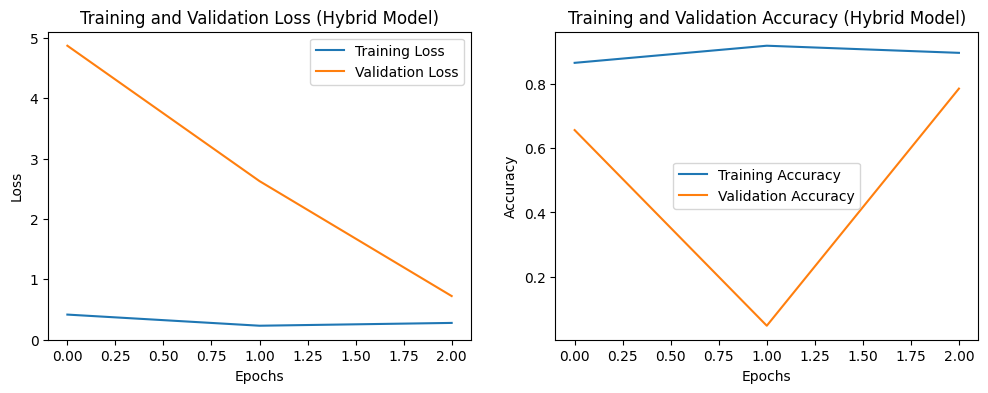

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hybrid_loss, label='Training Loss')
plt.plot(hybrid_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Hybrid Model)')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(hybrid_accuracy, label='Training Accuracy')
plt.plot(hybrid_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Hybrid Model)')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


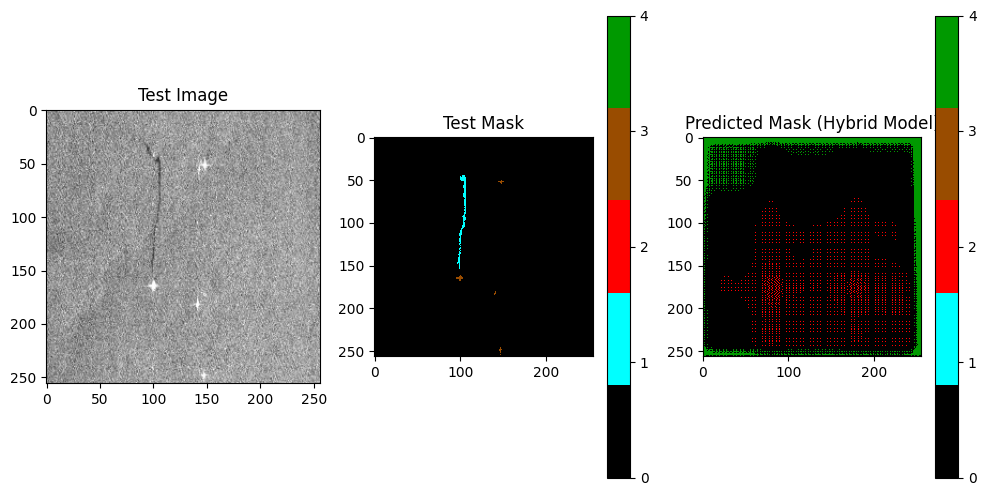

1/1 [==============================] - 0s 204ms/step


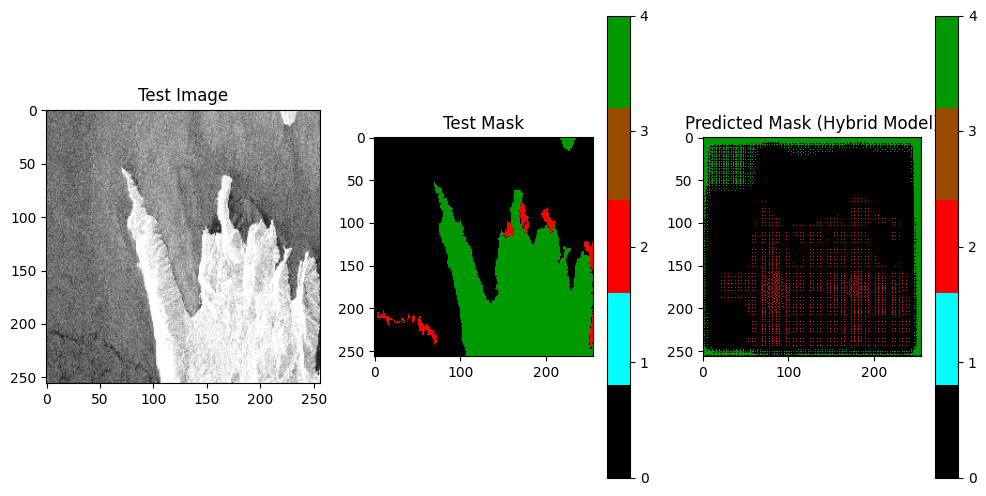

1/1 [==============================] - 0s 183ms/step


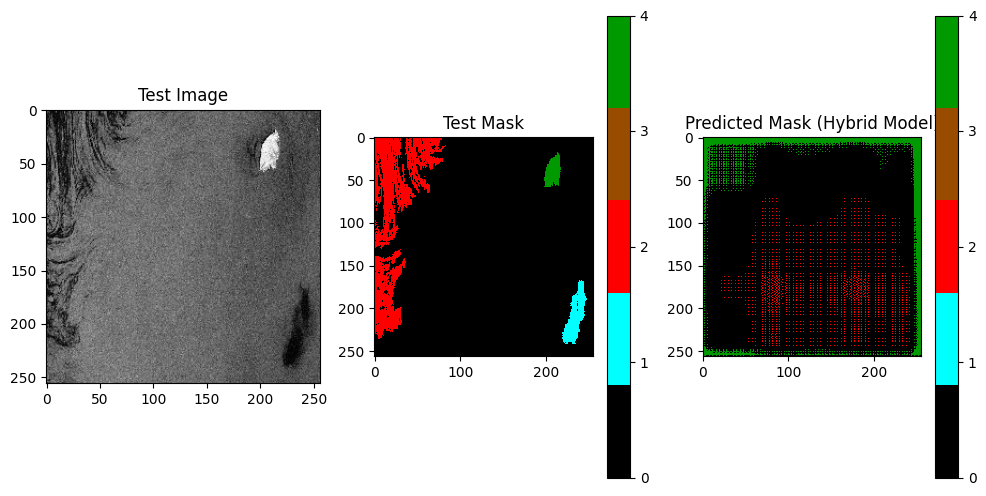

1/1 [==============================] - 0s 273ms/step


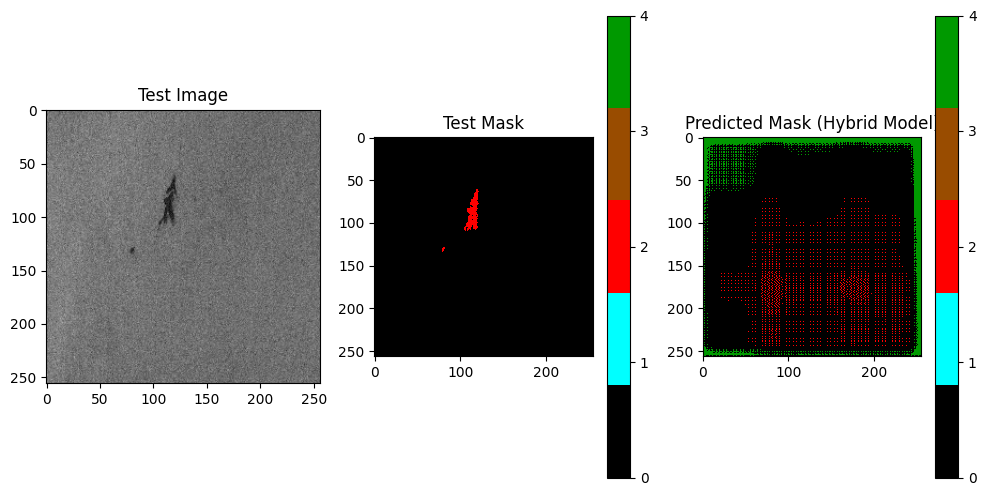

1/1 [==============================] - 0s 212ms/step


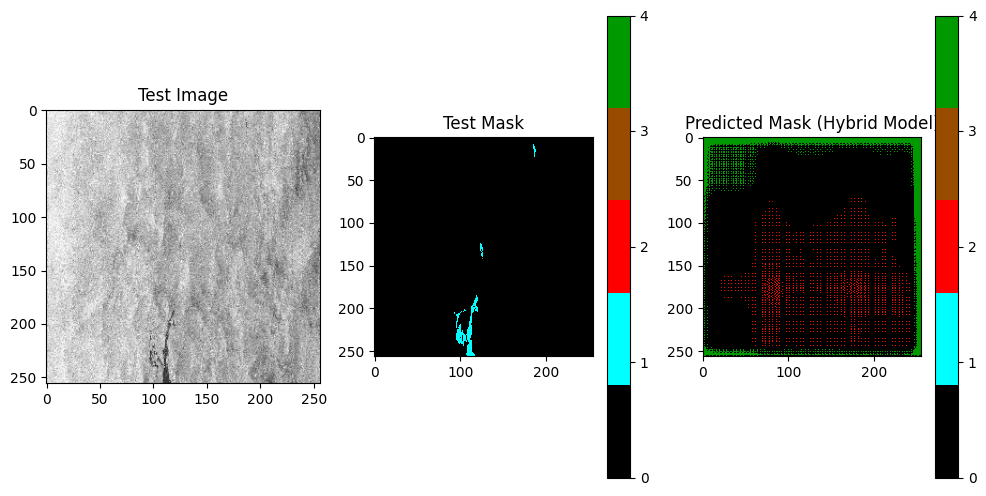

1/1 [==============================] - 0s 178ms/step


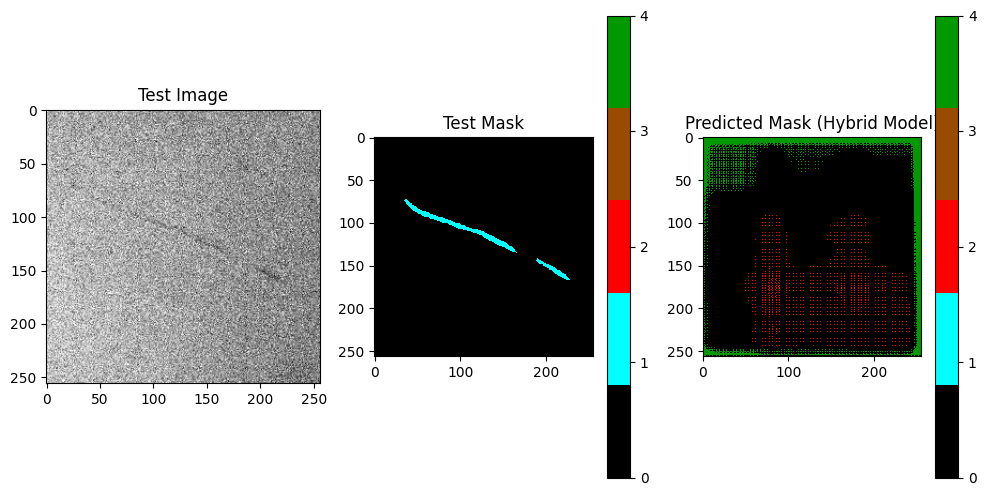

1/1 [==============================] - 0s 231ms/step


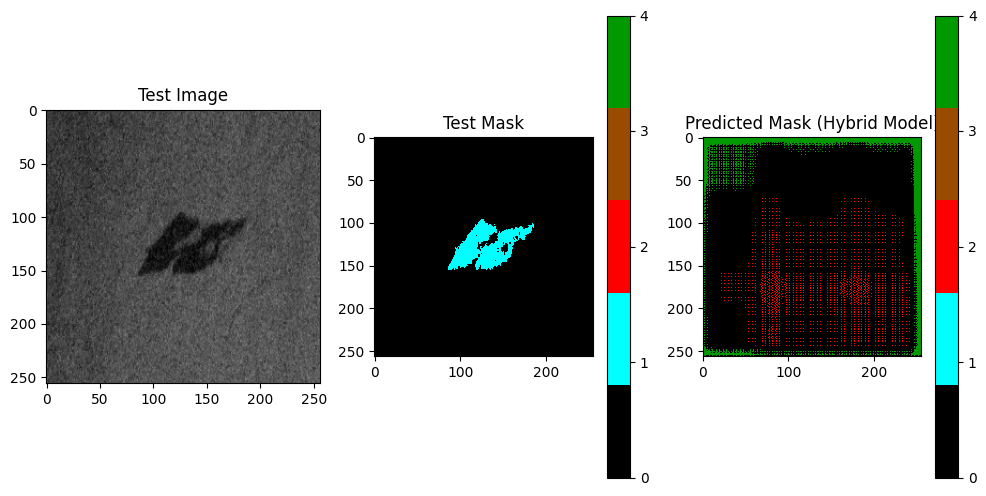

1/1 [==============================] - 0s 234ms/step


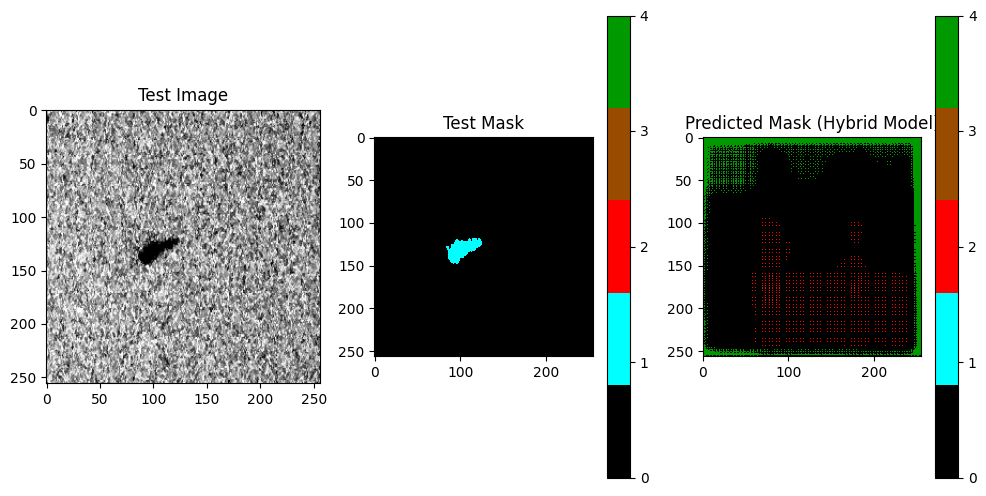

1/1 [==============================] - 0s 211ms/step


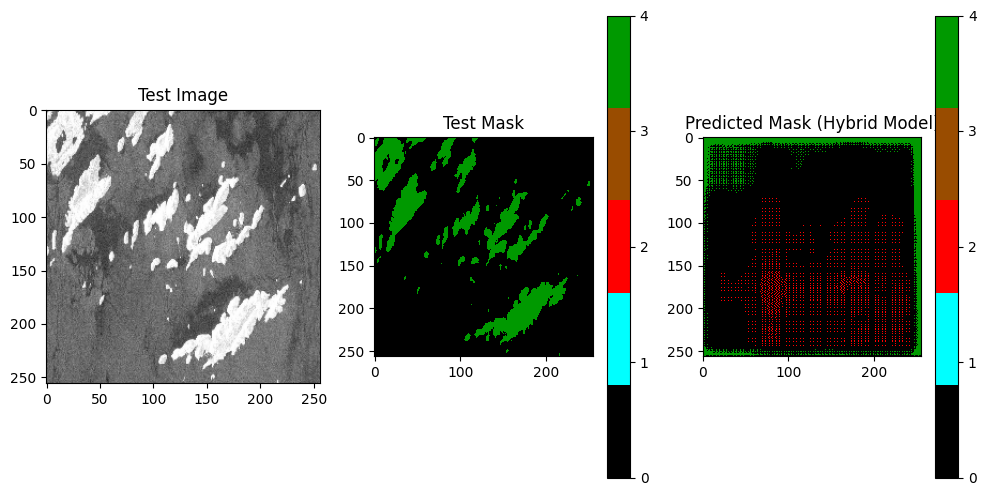

1/1 [==============================] - 0s 403ms/step


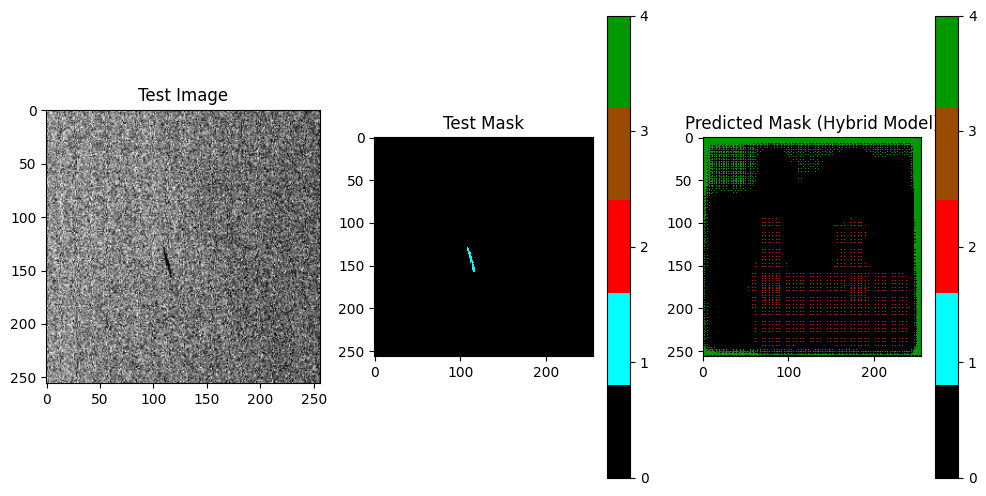

In [28]:
# Visualize predictions on test images
num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))
    
    # Test Image
    plt.subplot(1, 3, 1)
    test_image = test_images[i]
    plt.imshow(test_image)
    plt.title("Test Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    prediction_hybrid = hybrid_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_hybrid = np.argmax(prediction_hybrid, axis=3)[0, :, :]
    plt.imshow(predicted_mask_hybrid.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask (Hybrid Model)")
    
    plt.show()


In [29]:
# Evaluate the Hybrid Model
prediction_hybrid = hybrid_model.predict(test_images)
# Flatten the arrays to 1D
hybrid_true_labels = test_masks.flatten()
hybrid_predicted_labels = np.argmax(prediction_hybrid, axis=-1).flatten()

# Create the confusion matrix
cm_hybrid = confusion_matrix(hybrid_true_labels, hybrid_predicted_labels)

4/4 [==============================] - 17s 4s/step


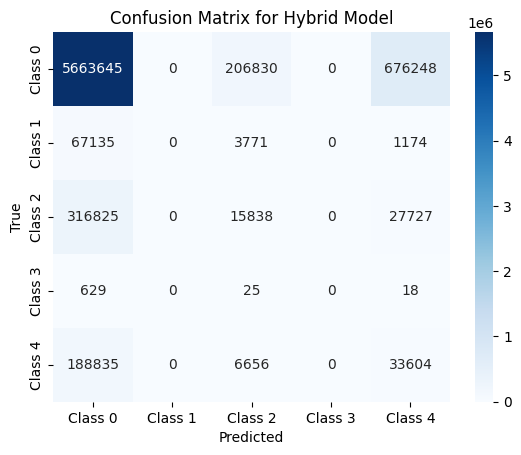

In [30]:
# Plot the confusion matrix
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Hybrid Model')
plt.show()

In [31]:
# Calculate Precision, Recall, and F1 Score
precision = precision_score(hybrid_true_labels, hybrid_predicted_labels, average='weighted')
recall = recall_score(hybrid_true_labels, hybrid_predicted_labels, average='weighted')
f1 = f1_score(hybrid_true_labels, hybrid_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

c:\Users\Uday Kiran Ambati\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.8295
Recall: 0.7925
F1 Score: 0.8095
